In [16]:
#数据预处理
import pandas as pd


def read_data(train_file="dataset/train.tsv"):
    train_df = pd.read_csv(train_file, sep='\t')
    # test_df = pd.read_csv(test_file, sep="\t")
    return train_df["Phrase"].values, train_df["Sentiment"].values

if __name__ == "__main__":
    X_data, y_data = read_data()
    print("train size", len(X_data))

train size 156060


In [17]:
import numpy as np

class BagOfWord:
    def __init__(self, do_lower_case=False):
        self.vocab = {}
        self.do_lower_case = do_lower_case

    def fit(self, sent_list):
        # sent_list 类型为 List
        for sent in sent_list:
            if self.do_lower_case:
                sent = sent.lower()
            words = sent.strip().split(" ")
            for word in words:
                if word not in self.vocab:
                    self.vocab[word] = len(self.vocab)

    def transform(self, sent_list):
        vocab_size = len(self.vocab)
        bag_of_word_feature = np.zeros((len(sent_list), vocab_size))
        for idx, sent in enumerate(sent_list):
            if self.do_lower_case:
                sent = sent.lower()
            words = sent.strip().split(" ")
            for word in words:
                bag_of_word_feature[idx][self.vocab[word]] += 1
        return bag_of_word_feature

    def fit_transform(self, sent_list):
        self.fit(sent_list)
        return self.transform(sent_list)


class NGram:
    def __init__(self, ngram, do_lower_case=False):
        self.ngram = ngram
        self.feature_map = {}
        self.do_lower_case = do_lower_case

    def fit(self, sentList):
        for gram in self.ngram:
            for sent in sentList:
                if self.do_lower_case:
                    sent = sent.lower()
                sent = sent.split(" ")
                for i in range(len(sent) - gram + 1):
                    feature = "_".join(sent[i:i + gram])
                    if feature not in self.feature_map:
                        self.feature_map[feature] = len(self.feature_map)

    def transform(self, sentList):
        n = len(sentList)
        m = len(self.feature_map)
        ngram_feature = np.zeros((n, m))
        for idx, sent in enumerate(sentList):
            if self.do_lower_case:
                sent = sent.lower()
            sent = sent.split(" ")
            for gram in self.ngram:
                for i in range(len(sent) - gram + 1):
                    feature = "_".join(sent[i:i + gram])
                    if feature in self.feature_map:
                        ngram_feature[idx][self.feature_map[feature]] = 1
        return ngram_feature

    def fit_transform(self, sentList):
        self.fit(sentList)
        return self.transform(sentList)




In [18]:
import numpy as np

def softmax(z):
    # 稳定版本的softmax，对z的每一行进行softmax
    z -= np.max(z, axis=1, keepdims=True)  # 先减去该行的最大值
    z = np.exp(z)
    z /= np.sum(z, axis=1, keepdims=True)
    return z

class SoftmaxRegression:
    def __init__(self):
        self.num_of_class = None  # 类别数量
        self.n = None   # 数据个数
        self.m = None   # 数据维度
        self.weight = None  # 模型权重 shape (类别数，数据维度)
        self.learning_rate = None

    def fit(self, X, y, learning_rate=0.01, epoch=10, num_of_class=5, print_loss_steps=-1, update_strategy="batch"):
        self.n, self.m = X.shape
        self.num_of_class = num_of_class
        self.weight = np.random.randn(self.num_of_class, self.m)
        self.learning_rate = learning_rate

        # 将y换为独热码矩阵，每一行独热码表示一个label
        y_one_hot = np.zeros((self.n, self.num_of_class))
        for i in range(self.n):
            y_one_hot[i][y[i]] = 1

        loss_history = []

        for e in range(epoch):
            # X (n, m) 每一行表示一个样本
            # weight (C, m) 每一行处理一个类别
            loss = 0
            if update_strategy == "stochastic":
                rand_index = np.arange(len(X))
                np.random.shuffle(rand_index)
                for index in list(rand_index):
                    Xi = X[index].reshape(1, -1)
                    prob = Xi.dot(self.weight.T)
                    prob = softmax(prob).flatten()
                    loss += -np.log(prob[y[index]])
                    self.weight += Xi.reshape(1, self.m).T.dot((y_one_hot[index] - prob).reshape(1, self.num_of_class)).T

            if update_strategy == "batch":
                prob = X.dot(self.weight.T)   # (n, C) 每个样本被预测为各个类别
                prob = softmax(prob)

                for i in range(self.n):
                    loss -= np.log(prob[i][y[i]])

                # 书中给的损失函数
                weight_update = np.zeros_like(self.weight)
                for i in range(self.n):
                    weight_update += X[i].reshape(1, self.m).T.dot((y_one_hot[i] - prob[i]).reshape(1, self.num_of_class)).T
                self.weight += weight_update * self.learning_rate / self.n

            loss /= self.n
            loss_history.append(loss)
            if print_loss_steps != -1 and e % print_loss_steps == 0:
                print("epoch {} loss {}".format(e, loss))
        return loss_history

    def predict(self, X):
        prob = softmax(X.dot(self.weight.T))
        return prob.argmax(axis=1)

    def score(self, X, y):
        pred = self.predict(X)
        return np.sum(pred.reshape(y.shape) == y) / y.shape[0]

Bow shape (1000, 363)
Gram shape (1000, 968)
epoch 0 loss [3.31975036]
epoch 10 loss [1.62211664]
epoch 20 loss [1.7196269]
epoch 30 loss [1.44989284]
epoch 40 loss [1.38371145]
epoch 50 loss [1.5085976]
epoch 60 loss [1.60540379]
epoch 70 loss [1.5564537]
epoch 80 loss [1.60100932]
epoch 90 loss [1.58555207]


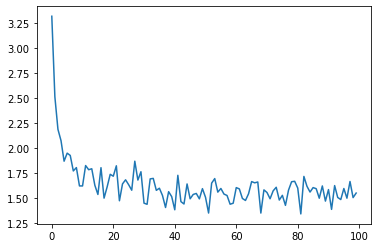

Bow train 0.83125 test 0.47
epoch 0 loss [3.78462169]
epoch 10 loss [1.12569395]
epoch 20 loss [0.46344282]
epoch 30 loss [0.21945219]
epoch 40 loss [0.25551328]
epoch 50 loss [0.06632553]
epoch 60 loss [0.09212925]
epoch 70 loss [0.09075686]
epoch 80 loss [0.02039843]
epoch 90 loss [0.04294364]


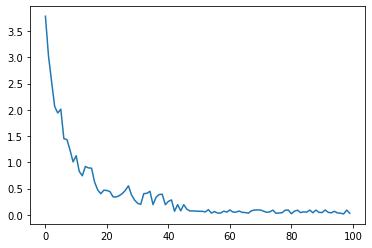

Gram train 0.9975 test 0.52


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

if __name__ == '__main__':
    debug = 1
    # 读入数据
    X_data, y_data = read_data()

    if debug == 1:
        # index = np.arange(len(X_data))
        # np.random.shuffle(index)
        # X_data = X_data[index[:2000]]
        # y_data = y_data[index[:2000]]
        X_data = X_data[:1000]
        y_data = y_data[:1000]
    y = np.array(y_data).reshape(len(y_data), 1)

    # 数据集划分
    bag_of_word_model = BagOfWord(do_lower_case=True)
    ngram_model = NGram(ngram=(1, 2), do_lower_case=True)
    X_Bow = bag_of_word_model.fit_transform(X_data)
    X_Gram = ngram_model.fit_transform(X_data)

    print("Bow shape", X_Bow.shape)
    print("Gram shape", X_Gram.shape)

    X_train_Bow, X_test_Bow, y_train_Bow, y_test_Bow = train_test_split(X_Bow, y, test_size=0.2, random_state=42, stratify=y)
    X_train_Gram, X_test_Gram, y_train_Gram, y_test_Gram = train_test_split(X_Gram, y, test_size=0.2, random_state=42, stratify=y)

    # 训练模型 不同特征的差别
    epoch = 100
    bow_learning_rate = 1
    gram_learning_rate = 1

    # 梯度下降
    model1 = SoftmaxRegression()
    history = model1.fit(X_train_Bow, y_train_Bow, epoch=epoch, learning_rate=bow_learning_rate, print_loss_steps=epoch//10, update_strategy="stochastic")
    plt.plot(np.arange(len(history)), np.array(history))
    plt.show()
    print("Bow train {} test {}".format(model1.score(X_train_Bow, y_train_Bow), model1.score(X_test_Bow, y_test_Bow)))

    model2 = SoftmaxRegression()
    history = model2.fit(X_train_Gram, y_train_Gram, epoch=epoch, learning_rate=gram_learning_rate, print_loss_steps=epoch//10, update_strategy="stochastic")
    plt.plot(np.arange(len(history)), np.array(history))
    plt.show()
    print("Gram train {} test {}".format(model2.score(X_train_Gram, y_train_Gram), model2.score(X_test_Gram, y_test_Gram)))